In [2]:
# =============================================
# Menstrual Irregularity Prediction (RHQ031)
# =============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1️⃣ Load dataset
# -------------------------------
df = pd.read_csv("Merged_Dataset.csv")

# -------------------------------
# 2️⃣ Target
# -------------------------------
target = "RHQ031"
df = df[df[target].notna()]
df[target] = df[target].map({'Yes': 1, 'No': 0})
df['INDFMPIR'] = pd.to_numeric(df['INDFMPIR'].replace({'≥ 5.00': 5}), errors='coerce')

# -------------------------------
# 3️⃣ Top features
# -------------------------------
top_features = [
    'RIDAGEYR', 'RHD280', 'RHQ540', 'DMDHHSIZ',
    'RHQ305', 'DMDMARTL', 'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN'
]

categorical_features = [f for f in top_features if f in [
    'RIDRETH3', 'RHQ010', 'RHQ160',
    'DMDMARTL', 'DMDHHSIZ', 'RHQ540', 'RHQ305', 'RHD280'
]]

# -------------------------------
# 4️⃣ Split dataset
# -------------------------------
X = df[top_features].copy()
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 5️⃣ Encode categorical features
# -------------------------------
if categorical_features:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train[categorical_features] = enc.fit_transform(X_train[categorical_features].astype(str))
    X_test[categorical_features] = enc.transform(X_test[categorical_features].astype(str))

# -------------------------------
# 6️⃣ Impute missing values
# -------------------------------
imputer = SimpleImputer(strategy="mean")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# -------------------------------
# 7️⃣ Normalize features
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 8️⃣ Define models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
}

# -------------------------------
# 9️⃣ Train and evaluate
# -------------------------------
results = []
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else y_pred
    results.append({
        "Model": model_name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "F1 Score": round(f1_score(y_test, y_pred), 4),
        "ROC-AUC": round(roc_auc_score(y_test, y_prob), 4)
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
results_df.to_csv("Menstrual_Model_TopFeatures_Results.csv", index=False)
print("\n✅ Training complete! Top results:\n", results_df.head(10))

# -------------------------------
# 🔟 Save model and preprocessing
# -------------------------------
best_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)

joblib.dump(best_model, "Menstrual_RF_Model.pkl")
joblib.dump(enc, "Menstrual_OrdinalEncoder.pkl")
joblib.dump(imputer, "Menstrual_Imputer.pkl")
joblib.dump(scaler, "Menstrual_Scaler.pkl")
print("✅ Model and preprocessing saved!")



✅ Training complete! Top results:
                  Model  Accuracy  F1 Score  ROC-AUC
0  Logistic Regression    0.8863    0.9072   0.9389
1              XGBoost    0.8835    0.9032   0.9296
2        Random Forest    0.8791    0.8998   0.9266
✅ Model and preprocessing saved!


In [3]:
# =============================================
# Menstrual Irregularity Prediction (Classification)
# =============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib

# -------------------------------
# 1️⃣ Load dataset
# -------------------------------
df = pd.read_csv("Merged_Dataset.csv")

# -------------------------------
# 2️⃣ Define target
# -------------------------------
target = "RHQ031"
df = df[df[target].notna()]
df[target] = df[target].map({'Yes': 1, 'No': 0})

# Fix mixed values
df['INDFMPIR'] = pd.to_numeric(df['INDFMPIR'].replace({'≥ 5.00': 5}), errors='coerce')

# -------------------------------
# 3️⃣ Select top features
# -------------------------------
features = [
    'RIDAGEYR', 'RHD280', 'RHQ540',
    'RHQ305', 'DMDMARTL', 'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN'
]

X = df[features]
y = df[target]

# Save raw features used
with open("Menstrual_features.txt", "w") as f:
    for feat in features:
        f.write(feat + "\n")

# -------------------------------
# 4️⃣ Split dataset
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -------------------------------
# 5️⃣ Identify categorical & numeric columns
# -------------------------------
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numeric_features = [col for col in X.columns if col not in categorical_features]

# -------------------------------
# 6️⃣ Preprocessing pipeline
# -------------------------------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# -------------------------------
# 7️⃣ Combine preprocessor + model
# -------------------------------
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# -------------------------------
# 8️⃣ Train model
# -------------------------------
model.fit(X_train, y_train)

# -------------------------------
# 9️⃣ Evaluate
# -------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n✅ Menstrual Model Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# -------------------------------
# 🔟 Save full pipeline + model
# -------------------------------
joblib.dump(model, "Menstrual_Pipeline_Model.joblib")
print("\n💾 Saved Menstrual_Pipeline_Model.joblib successfully!")



✅ Menstrual Model Results:
Accuracy: 0.8878
F1 Score: 0.9071
ROC-AUC: 0.9261

💾 Saved Menstrual_Pipeline_Model.joblib successfully!


In [4]:
# =============================================
# 🔍 Test the Menstrual Irregularity Model
# =============================================

import pandas as pd
import joblib

# -------------------------------
# 1️⃣ Load the saved model
# -------------------------------
model = joblib.load("Menstrual_Pipeline_Model.joblib")
print("✅ Model loaded successfully!")

# -------------------------------
# 2️⃣ Prepare new test data
# -------------------------------
# ⚠️ Ensure all columns match the training features exactly:
# ['RIDAGEYR', 'RHD280', 'RHQ540', 'RHQ305', 'DMDMARTL', 
#  'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN']

test_data = pd.DataFrame([{
    'RIDAGEYR': 35,      # Age in years
    'RHD280': 'No',      # Had a hysterectomy?
    'RHQ540': 'Yes',     # Ever use female hormones?
    'RHQ305': 'NO', # Had both ovaries removed?
    'DMDMARTL': 'MARRIED', # Marital status
    'LBXBPB': 2.1,       # Blood lead (µg/dL)
    'LBXBCD': 0.34,      # Blood cadmium (µg/L)
    'LBXTHG': 0.65,      # Blood mercury (µg/L)
    'LBXBSE': 0.72,      # Blood selenium (µg/L)
    'LBXBMN': 1.12       # Blood manganese (µg/L)
}])

print("\n📘 Input Data:")
display(test_data)

# -------------------------------
# 3️⃣ Make predictions
# -------------------------------
predicted_class = model.predict(test_data)[0]
predicted_prob = model.predict_proba(test_data)[0][1]

# -------------------------------
# 4️⃣ Display results
# -------------------------------
if predicted_class == 1:
    print(f"\n🎯 Prediction: Menstrual Irregularity = YES (probability: {predicted_prob:.2f})")
else:
    print(f"\n🎯 Prediction: Menstrual Irregularity = NO (probability: {predicted_prob:.2f})")


✅ Model loaded successfully!

📘 Input Data:


,RIDAGEYR,RHD280,RHQ540,RHQ305,DMDMARTL,LBXBPB,LBXBCD,LBXTHG,LBXBSE,LBXBMN
0,35,No,Yes,NO,MARRIED,2.1,0.34,0.65,0.72,1.12



🎯 Prediction: Menstrual Irregularity = YES (probability: 0.70)


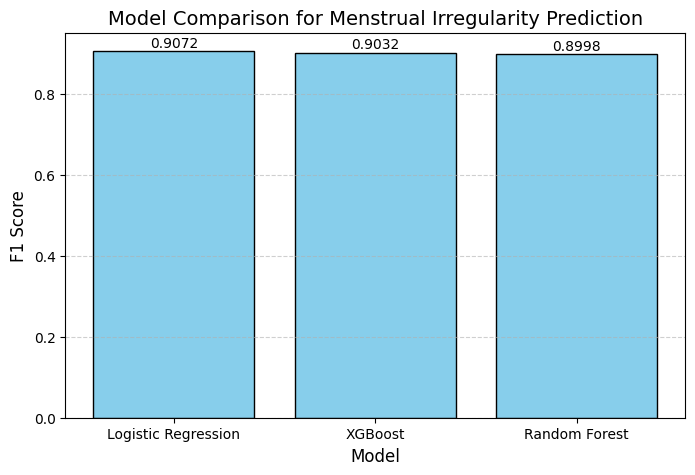

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load model results
results_df = pd.read_csv("Menstrual_Model_TopFeatures_Results.csv")

plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["F1 Score"], color='skyblue', edgecolor='black')
plt.title("Model Comparison for Menstrual Irregularity Prediction", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(results_df["F1 Score"]):
    plt.text(i, v + 0.01, str(v), ha='center', fontsize=10)
plt.show()


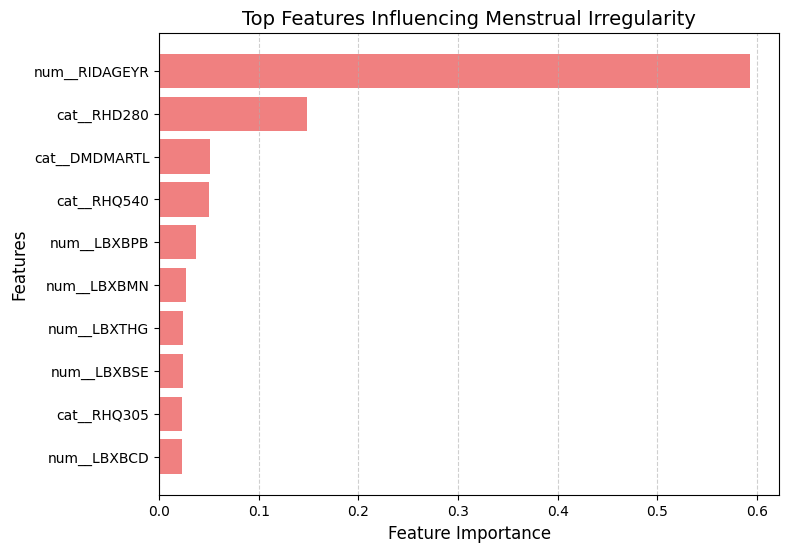

In [11]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load pipeline model
model = joblib.load("Menstrual_Pipeline_Model.joblib")
classifier = model.named_steps['classifier']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": classifier.feature_importances_
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(importances["Feature"], importances["Importance"], color='lightcoral')
plt.title("Top Features Influencing Menstrual Irregularity", fontsize=14)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


RuntimeError: `logistic=True` requires statsmodels, an optional dependency, to be installed.

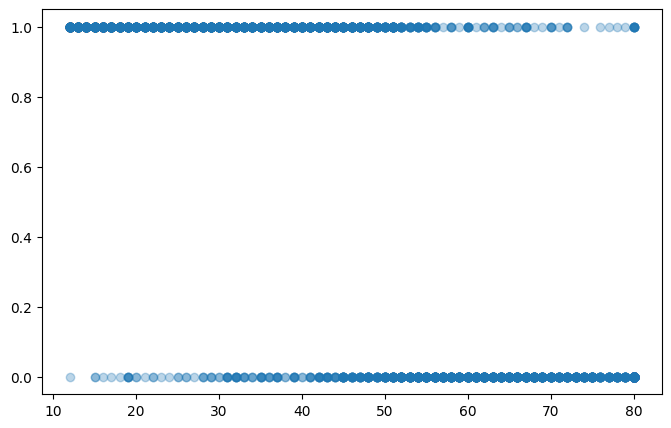

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("Merged_Dataset.csv")
df['RHQ031'] = df['RHQ031'].map({'Yes': 1, 'No': 0})

plt.figure(figsize=(8,5))
sns.regplot(x=df['RIDAGEYR'], y=df['RHQ031'], logistic=True, scatter_kws={'alpha':0.3})
plt.title("Relationship between Age and Menstrual Irregularity Probability", fontsize=14)
plt.xlabel("Age (Years)", fontsize=12)
plt.ylabel("Predicted Probability of Irregularity", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


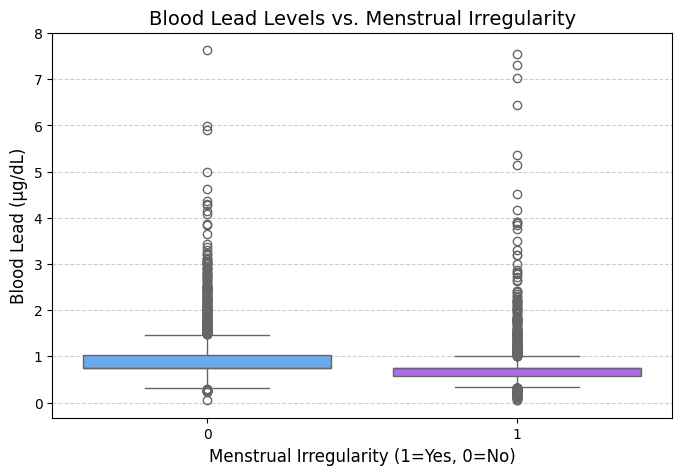

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='RHQ031', y='LBXBPB', data=df, palette='cool')
plt.title("Blood Lead Levels vs. Menstrual Irregularity", fontsize=14)
plt.xlabel("Menstrual Irregularity (1=Yes, 0=No)", fontsize=12)
plt.ylabel("Blood Lead (µg/dL)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


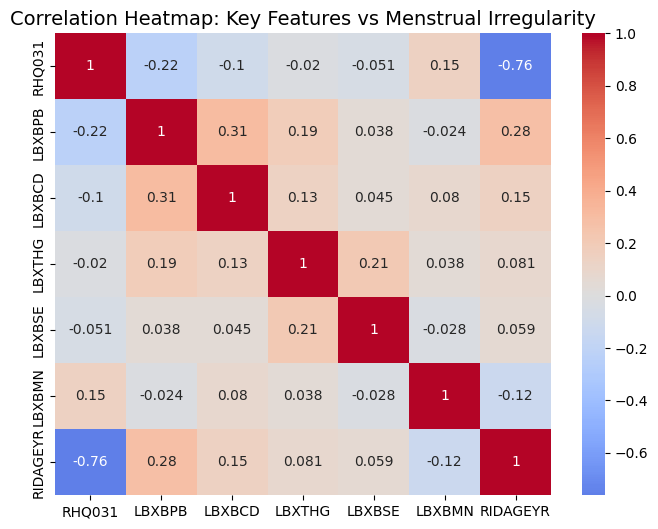

In [15]:
plt.figure(figsize=(8,6))
corr = df[['RHQ031', 'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN', 'RIDAGEYR']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap: Key Features vs Menstrual Irregularity", fontsize=14)
plt.show()
